In [1]:
!pip3 install -q --upgrade ipython keras scikit-learn
!pip3 install -q --upgrade ipykernel pillow seaborn pandas matplotlib opencv-python
!ls -la chest_Xray

total 36
drwxr-xr-x 5 mathou mathou  4096 mars  16 14:37 .
drwxr-xr-x 6 mathou mathou  4096 mai    5 11:19 ..
-rw-r--r-- 1 mathou mathou 12292 mars  16 14:37 .DS_Store
drwxr-xr-x 4 mathou mathou  4096 mars  16 14:37 test
drwxr-xr-x 4 mathou mathou  4096 mars  16 14:37 train
drwxr-xr-x 4 mathou mathou  4096 mars  16 14:37 val


In [2]:
import os
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
import cv2
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [3]:
TEST_PATH = "./chest_Xray/test"
TRAIN_PATH = "./chest_Xray/train"
VAL_PATH = "./chest_Xray/val"

# Creation of Train, Val and Test datasets

In [4]:
def create_dataset(PATH):
    X = []
    Y = []
    for elem in os.listdir(PATH):
        is_pneumonia = 0.
        if elem == "PNEUMONIA":
            is_pneumonia = 1.
        try:
            for filename in os.listdir(PATH + "/" + elem):
                try:
                    path = PATH + "/" + elem + "/"
                    img = cv2.imread(str(path+filename))
                    img = cv2.resize(img, (224,224))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img.astype(np.float32)/255.
                    # Data augmentation :
                    # Flip
                    flipped_image = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    # noisy_image = random_noise(img)
                    # Blur
                    #blur_image = cv2.GaussianBlur(img, (11,11),0)
                    # rotated_image = rotate(img, angle=45)
                    img_data = [img, flipped_image]
                    for image in img_data:
                        X.append(image)
                        Y.append(is_pneumonia)
                except:
                    print(filename + " failed")
                    pass
        except:
            pass
    X = np.array(X).reshape(-1, 224*224*3)
    Y = np.array(Y)
    return X, Y

In [5]:
train_X, train_Y = create_dataset(TRAIN_PATH)
val_X, val_Y = create_dataset(VAL_PATH)
test_X, test_Y = create_dataset(TEST_PATH)

.DS_Store failed
.DS_Store failed
.DS_Store failed
.DS_Store failed


# Data exploration

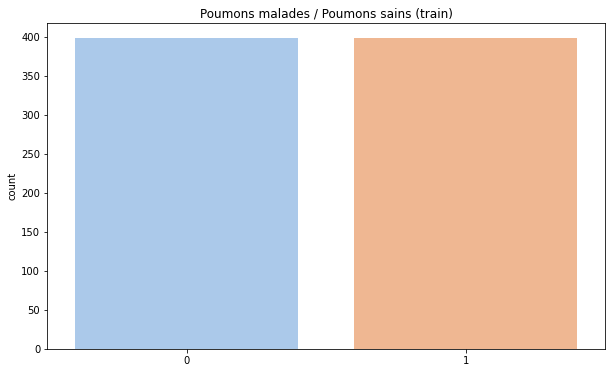

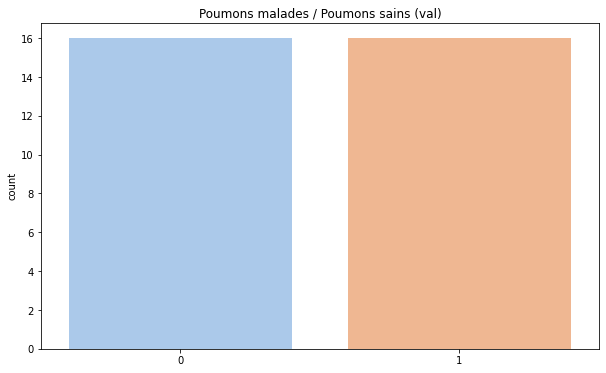

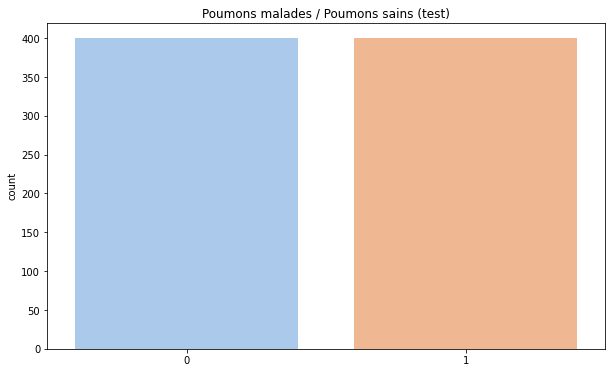

In [6]:
# PLOT POUMONS
labels = ["Normal", "Pneumonia"]

plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (train)")
sns.countplot(train_Y.astype(int), palette=sns.color_palette("pastel"))

plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (val)")
sns.countplot(val_Y.astype(int), palette=sns.color_palette("pastel"))

plt.figure(figsize=(10,6))
plt.title("Poumons malades / Poumons sains (test)")
sns.countplot(test_Y.astype(int), palette=sns.color_palette("pastel"))

# Creation and training step of the model

In [7]:
model = RandomForestClassifier(random_state = 20, n_estimators = 150, max_depth = 10, 
                               max_features = 2)
model.fit(train_X, train_Y)
scores = cross_val_score(model, val_X, val_Y)
print(str(scores.mean()) + " / " + str(scores.std()))

0.5666666666666667 / 0.28388302020550255


# Validation step

In [8]:
scores_preds = cross_val_predict(model, test_X, test_Y)
scores_probas = model.predict_proba(test_X)[:, 1]
print(str(scores_preds.mean()) + " / " + str(scores_preds.std()))

0.45375 / 0.497856342231371


# Test step : Final model accuracy

In [9]:
accuracy = roc_auc_score(test_Y, scores_preds)
print(accuracy)

0.90125


## Predictions and model metrics plots

Text(0.5, 1.0, 'ROC Curves')

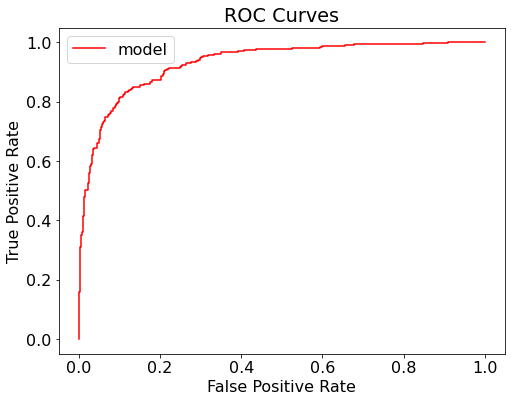

In [10]:
false_positive, true_positive, _ = roc_curve(test_Y, scores_probas)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(false_positive, true_positive, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

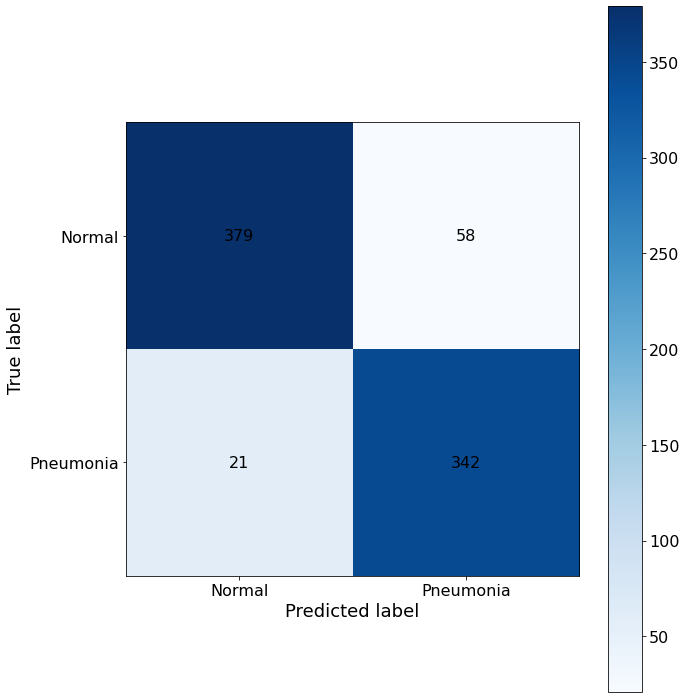

In [11]:
cm = confusion_matrix(test_Y, scores_preds)
classes = ['Normal', 'Pneumonia']
title = 'predictions HeatMap'
plt.figure(figsize = (10, 10))

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
for i in range(0, len(classes)):
    for j in range(0, len(classes)):
        text = plt.text(i, j, cm[i, j], ha="center", va="center")
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
plt.tight_layout()
plt.show()

## Predictions distribution

{'whiskers': [<matplotlib.lines.Line2D at 0x7f395b06b5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f395b074050>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f395b05fb50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f395b074ad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f395b07e090>,
 'means': []}

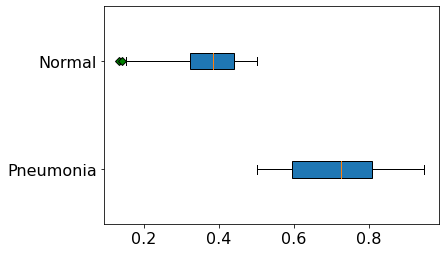

In [12]:
pneumonia = scores_probas[scores_probas.round()==True]
normal = scores_probas[scores_probas.round()==False]

green_diamond = dict(markerfacecolor='g', marker='D')

plt.boxplot([pneumonia, normal], labels=['Pneumonia', 'Normal'],
            flierprops=green_diamond, vert=False, patch_artist=True)